In [1]:
import findspark
findspark.init()

import time as t
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.streaming import StreamingContext
from pyspark.sql import functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta, date
import sys
from lib import sparkStructuredStreaming
import os
%matplotlib inline
from matplotlib import pyplot as plt
from pyspark.sql.window import Window
import math as m
import pandas as pd

### Set-up to stream from Kafka topic + read and write from/to Elasticsearch

In [2]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5,org.elasticsearch:elasticsearch-spark-20_2.11:7.6.2 pyspark-shell'

In [3]:
#"127.0.0.1:9092" (local) //"10.0.0.8:9092" (BACC)
bootstrap = "127.0.0.1:9092"
hdfs_path = "hdfs://0.0.0.0:19000"

In [4]:
spark = SparkSession \
            .builder \
            .appName("KafkaIEXStructuredStreamingRobovisor") \
            .master("local[*]") \
            .getOrCreate()

sqlContext = SQLContext(spark)

## 1. Backtesting

In [6]:
b = sparkStructuredStreaming.backtest()
hdfs_path = "hdfs://0.0.0.0:19000"
start = date(2020,6,3)
end = date(2020,6,3)

#strategy looks at last 10,120,500... minutes to calculate average
strategy_momentum = ["momentum",60,120]

# granularity of historical data
interval_momentum="1m"

#start capital
startCap = 10000.0
startCap_market = startCap

# regulatory trading fee
commission = 0.006

# risk free market return, assumed here 0.1% but is not really clear
risk_free = 0.001

# parameters to find stock symbols
n_stock = [2]
period = [2]

best_of = 5
    
b.full_backtest(startCap, startCap_market, commission, risk_free, strategy_momentum, interval_momentum, start, end, period, n_stock, hdfs_path, sqlContext, best_of, "static_no_best")

[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  456 of 456 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
per_comp = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_full/20200507").toPandas()
depot_comp = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/depot_full/20200507").toPandas()
perf_sim = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_best").toPandas()
depot_sim = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/depot_best").toPandas()

## Compare performance of different strategies on May 7th

In [10]:
df_perf = per_comp[["DepotId","Value","Alpha","Beta","Start-Capital","Profit","Trades","Performance_Strategy","Performance_S&P500"]].sort_values(by=['Performance_Strategy'],ascending=False)
df_perf = df_perf.rename(columns={"Value":"Value [$]","Start-Capital":"Start Capital [$]", "Profit":"Profit [$]", "Performance_Strategy":"Performance [%]","Performance_S&P500":"Market [%]"})
df_perf

,DepotId,Value [$],Alpha,Beta,Start Capital [$],Profit [$],Trades,Performance [%],Market [%]
27,62,10656.87,6.75,0.64,10000.0,656.87,61,6.57,-0.29
48,63,10520.94,5.40,0.65,10000.0,520.94,27,5.21,-0.29
91,5,10178.96,2.09,1.03,10000.0,178.96,3,1.79,-0.29
6,61,10115.13,1.31,0.56,10000.0,115.13,222,1.15,-0.29
32,92,10103.78,1.22,0.64,10000.0,103.78,54,1.04,-0.29
...,...,...,...,...,...,...,...,...,...
8,11,9322.48,-6.51,0.90,10000.0,-677.52,1383,-6.78,-0.29
4,71,9304.73,-6.67,0.97,10000.0,-695.27,1566,-6.95,-0.29
14,26,9267.40,-7.13,0.67,10000.0,-732.60,944,-7.33,-0.29
13,86,9203.21,-7.73,0.81,10000.0,-796.79,1334,-7.97,-0.29


In [12]:
merged = df_perf.merge(depot_comp, how="left", on="DepotId")[["DepotId","Strategy","ISIN","Share"]]
merged = merged.rename(columns={"Share":"Share [%]"})
merged

,DepotId,Strategy,ISIN,Share [%]
0,62,momentum60,"[HOLX, FLIR]","[0.67, 0.33]"
1,63,momentum120,"[HOLX, FLIR]","[0.67, 0.33]"
2,5,Buy and Hold,"[FLIR, ATVI]","[0.67, 0.33]"
3,61,momentum10,"[HOLX, FLIR]","[0.67, 0.33]"
4,92,momentum60,"[HOLX, ATVI]","[0.67, 0.33]"
...,...,...,...,...
100,11,momentum10,"[FLIR, ATVI, KLAC, DVA, BWA, WY, FFIV, AOS, AL...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
101,71,momentum10,"[HOLX, FLIR, DVN, FFIV, ALGN, PKI, PYPL, EBAY,...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
102,26,momentum10,"[ATVI, PCG, CLX, IPGP, VRTX, REGN, HOLX, CTXS,...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."
103,86,momentum10,"[HOLX, PCG, EBAY, IPGP, PYPL, EFX, LOW, PKI, A...","[0.18, 0.16, 0.15, 0.13, 0.11, 0.09, 0.07, 0.0..."


## Simulate Trading from May 11th - June 3rd by chossing the strategy which worked best the day before

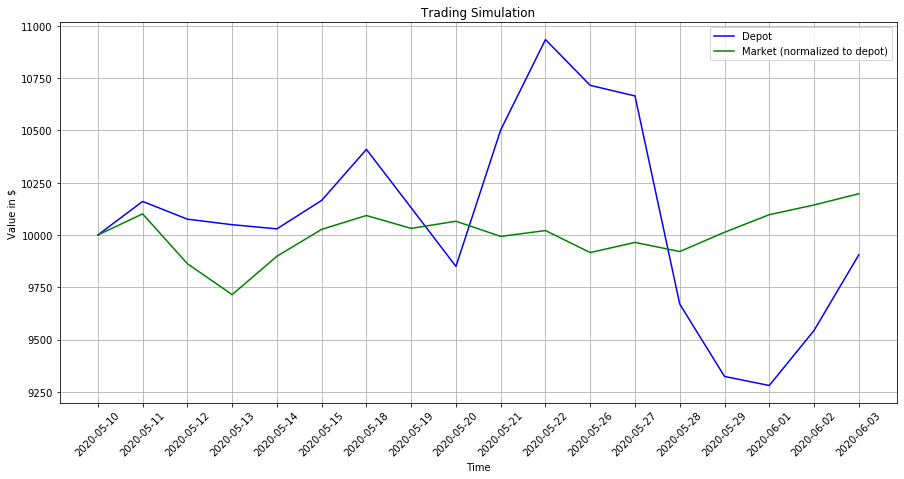

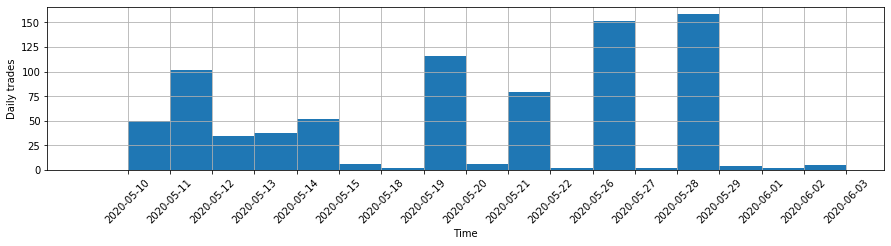

In [57]:
performance_best = sqlContext.read.format('parquet').load(hdfs_path+"/backtest/performance_best").orderBy("DepotId")
performance_best_col = performance_best.collect()
n = len(performance_best_col)
start_vals = performance_best_col[0]

date_list = [(start_vals['Start-Date']-timedelta(days=1)).strftime("%Y-%m-%d")]
trades = [0, 0]
performance = [start_vals['Start-Capital']]
performance_snp = [start_vals['Start-Capital_S&P500']]

for row in performance_best_col:
    date_list.append(row['Start-Date'].strftime("%Y-%m-%d"))
    performance.append(row["Value"])
    performance_snp.append(row["Value_S&P500"]) 
    trades.append(row["Trades"])

trades_daily = [trades[i]-trades[i-1] for i in range(1,len(trades))] 
plt.figure(figsize=[15,7])

plt.plot(date_list,performance,'b',label="Depot")
plt.plot(date_list,performance_snp,'g', label="Market (normalized to depot)")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Value in $")
plt.legend()
plt.title("Trading Simulation")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=[15,3])
plt.grid()
plt.xlabel("Time")
plt.ylabel("Daily trades")
plt.xticks(rotation=45)
plt.bar(date_list, trades_daily, width = -1, align = "edge")
plt.show()

In [14]:
perf_sim_pretty = perf_sim[["DepotId","Value","Alpha","Beta","Start-Capital","Profit","Start-Date","Performance_Strategy","Performance_S&P500"]].sort_values(by=['Start-Date'],ascending=True)
perf_sim_pretty = perf_sim_pretty.rename(columns={"Value":"Value [$]","Start-Capital":"Start Capital [$]","Start-Date":"Day", "Profit":"Profit [$]", "Performance_Strategy":"Performance [%]","Performance_S&P500":"Market [%]"})
perf_sim_pretty

,DepotId,Value [$],Alpha,Beta,Start Capital [$],Profit [$],Day,Performance [%],Market [%]
5,1,10160.58,-0.21,1.80,10000.00,160.58,2020-05-11,1.61,1.01
3,2,10075.65,2.40,1.37,10160.58,-84.93,2020-05-12,-0.84,-2.36
8,3,10049.17,-0.10,0.11,10075.65,-26.48,2020-05-13,-0.26,-1.50
11,4,10029.27,-0.62,0.22,10049.17,-19.90,2020-05-14,-0.20,1.89
4,5,10165.37,0.06,1.00,10029.27,136.10,2020-05-15,1.36,1.30
0,6,10409.53,0.96,2.19,10165.37,244.16,2020-05-18,2.40,0.66
7,7,10130.08,-1.62,1.74,10409.53,-279.45,2020-05-19,-2.68,-0.61
1,8,9849.66,-2.96,0.55,10130.08,-280.42,2020-05-20,-2.77,0.34
14,9,10502.50,NaN,NaN,9849.66,652.84,2020-05-21,6.63,-0.72
15,10,10934.73,NaN,NaN,10502.50,432.23,2020-05-22,4.12,0.28


In [16]:
depot_sim_pretty = depot_sim[["DepotId","Strategy","ISIN","Share"]].sort_values(by=['DepotId'],ascending=True)
depot_sim_pretty = depot_sim_pretty.rename(columns={"Share":"Share [%]"})
depot_sim_pretty

,DepotId,Strategy,ISIN,Share [%]
10,1,momentum120,"[LNC, BHF]","[0.5, 0.5]"
9,2,momentum120,"[NKTR, HP]","[0.5, 0.5]"
8,3,momentum120,"[ABBV, OKE]","[0.5, 0.5]"
11,4,momentum120,"[GIS, MKC]","[0.5, 0.5]"
12,5,momentum60,"[CTAS, BLK]","[0.5, 0.5]"
2,6,Buy and Hold,"[CTAS, FLR]","[0.5, 0.5]"
1,7,Buy and Hold,"[RCL, EXPE]","[0.5, 0.5]"
16,8,momentum60,"[RRC, UAL]","[0.5, 0.5]"
5,9,Buy and Hold,"[ARNC, RE]","[0.5, 0.5]"
14,10,momentum60,"[ARNC, LB]","[0.5, 0.5]"


## 2. Trading Simulation / Performance Evaluation with realtime Streams (Spark Streaming)

### Stream real time quotes from Kafka topic

In [6]:
r = sparkStructuredStreaming.realtime()
day = date(2020,6,4)
sandbox = False
commission = 0.006
startCap = 9.74965+286*18.04+636*8.3
trades = 26

r.realtime(startCap, day, sandbox, commission, sqlContext, trades)

[*********************100%***********************]  456 of 456 completed
{'value': 10444.2191, 'date': '2020-06-04T15:05:26', 'depotid': '20200604', 'trades': 27}
{'value': 10489.559599999999, 'date': '2020-06-04T15:06:08', 'depotid': '20200604', 'trades': 37} stocks:  ['M', 'DXC'] [1239, 0] cash 8.858599999999383
{'value': 10514.3396, 'date': '2020-06-04T15:06:56', 'depotid': '20200604', 'trades': 37} stocks:  ['M', 'DXC'] [1239, 0] cash 8.858599999999383
{'value': 10477.1696, 'date': '2020-06-04T15:07:40', 'depotid': '20200604', 'trades': 37} stocks:  ['M', 'DXC'] [1239, 0] cash 8.858599999999383
{'value': 10421.4146, 'date': '2020-06-04T15:08:12', 'depotid': '20200604', 'trades': 37} stocks:  ['M', 'DXC'] [1239, 0] cash 8.858599999999383
{'value': 10260.344599999999, 'date': '2020-06-04T15:09:09', 'depotid': '20200604', 'trades': 38} stocks:  ['M', 'DXC'] [0, 0] cash 10260.344599999999
{'value': 10260.344599999999, 'date': '2020-06-04T15:09:45', 'depotid': '20200604', 'trades': 38} 

KeyboardInterrupt: 